In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

In [ ]:
# Load Dataset
features_30 = pd.read_csv("/Dataset_Path/Datasetfilename.csv")
features_30.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
# Check Structure and Missing Values
features_30.info()
features_30.isnull().sum().head()

# Observations:No missing values, Mix of spectral, rhythmic, and MFCC features
# Target column: label

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

filename            0
length              0
chroma_stft_mean    0
chroma_stft_var     0
rms_mean            0
dtype: int64

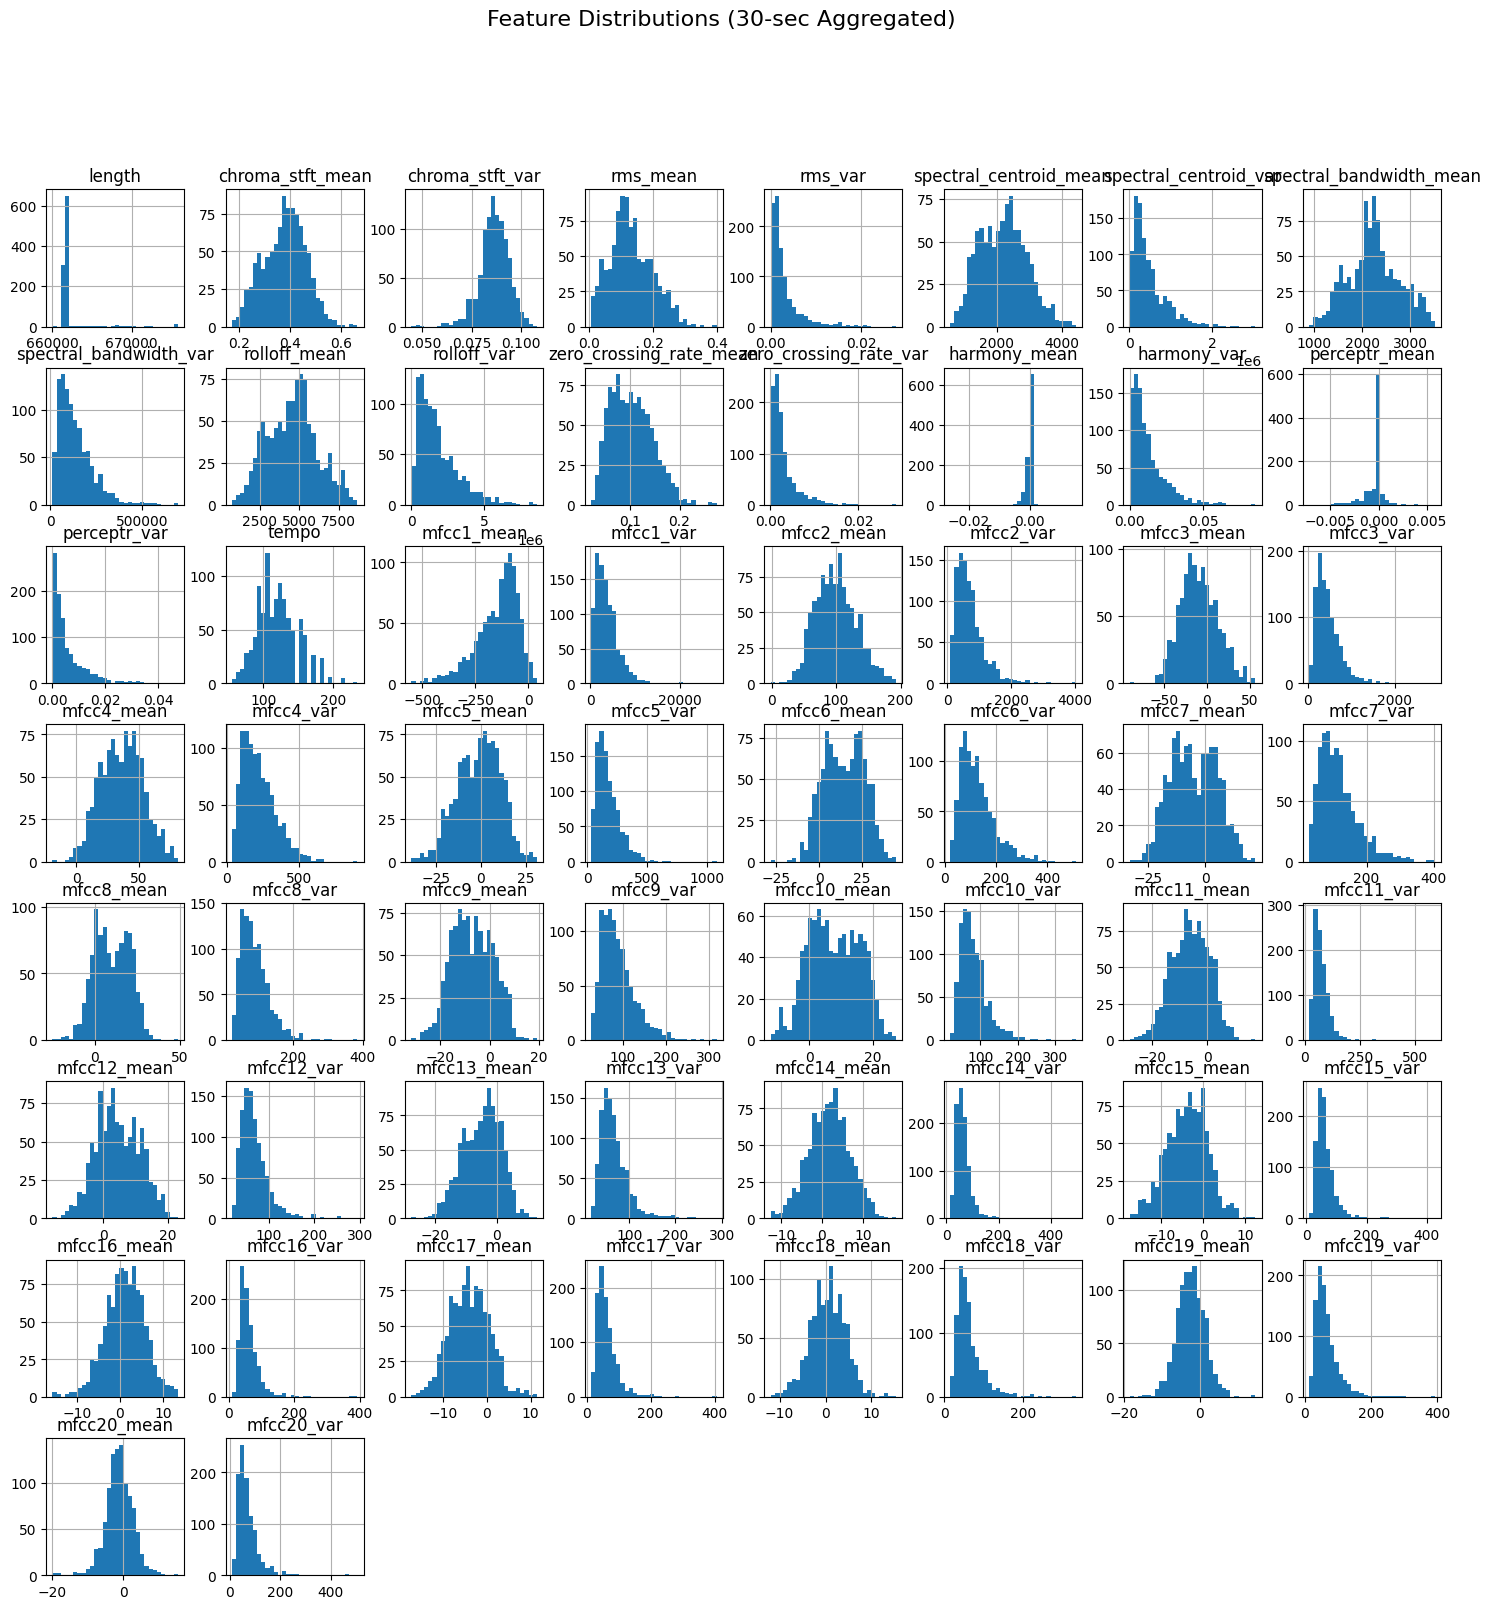

In [ ]:
# Feature Distributions
features_30.hist(figsize=(18, 18), bins=30)
plt.suptitle("Feature Distributions (30-sec Aggregated)", fontsize=16)
plt.show()
# Insight: Many features are right-skewed
# MFCC variances often show heavy tails
# Scaling will be required for ML models

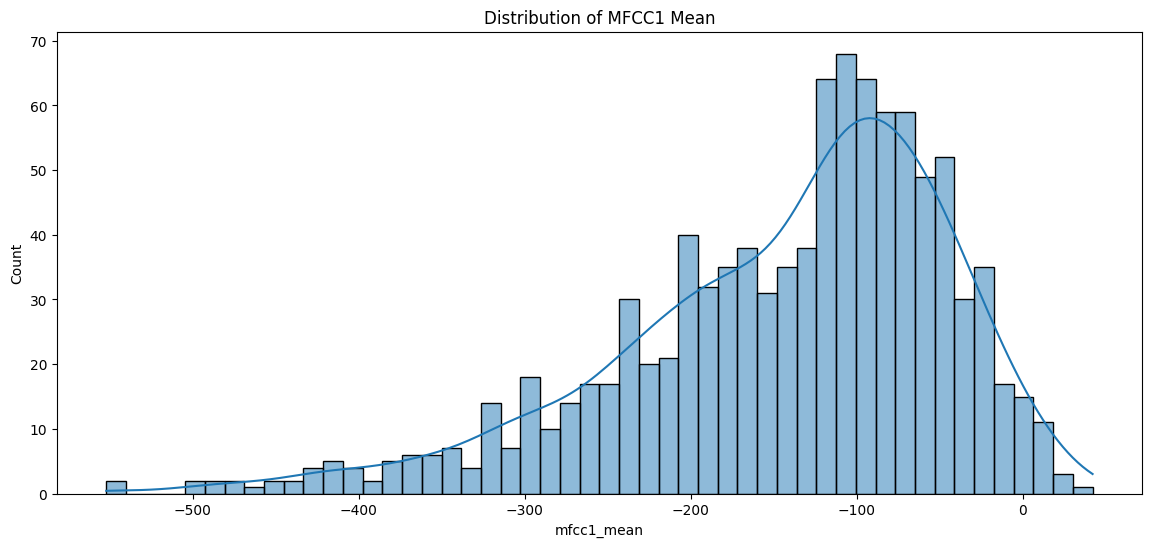

In [ ]:
# Feature Distributions
plt.figure(figsize=(14,6))
sns.histplot(features_30["mfcc1_mean"], bins=50, kde=True)
plt.title("Distribution of MFCC1 Mean")
plt.show()

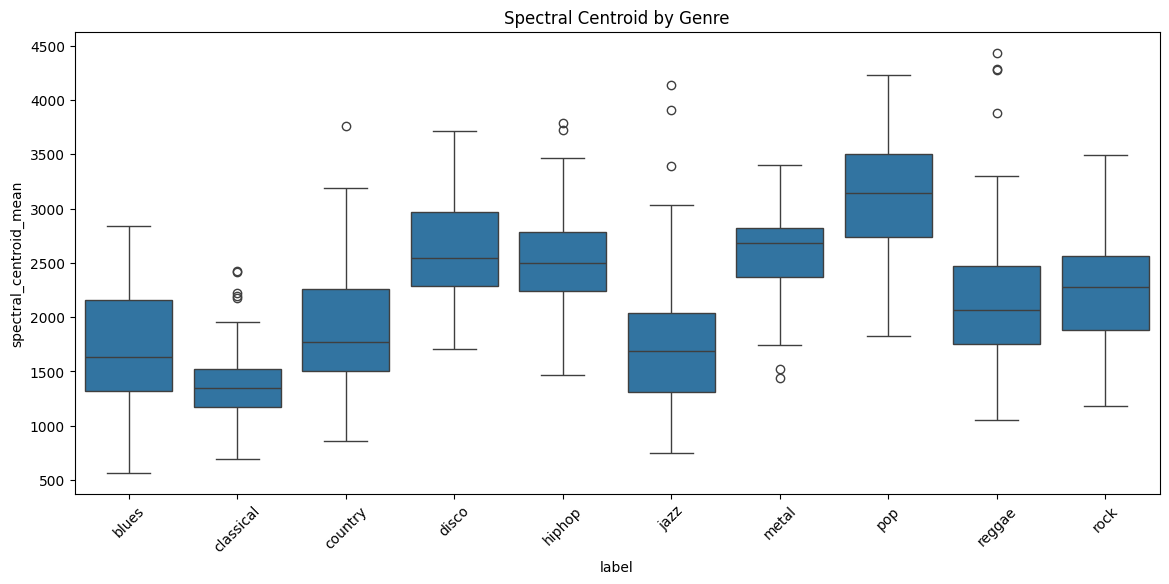

In [ ]:
# Spectral Centroid by Genre
plt.figure(figsize=(14,6))
sns.boxplot(x="label", y="spectral_centroid_mean", data=features_30)
plt.xticks(rotation=45)
plt.title("Spectral Centroid by Genre")
plt.show()


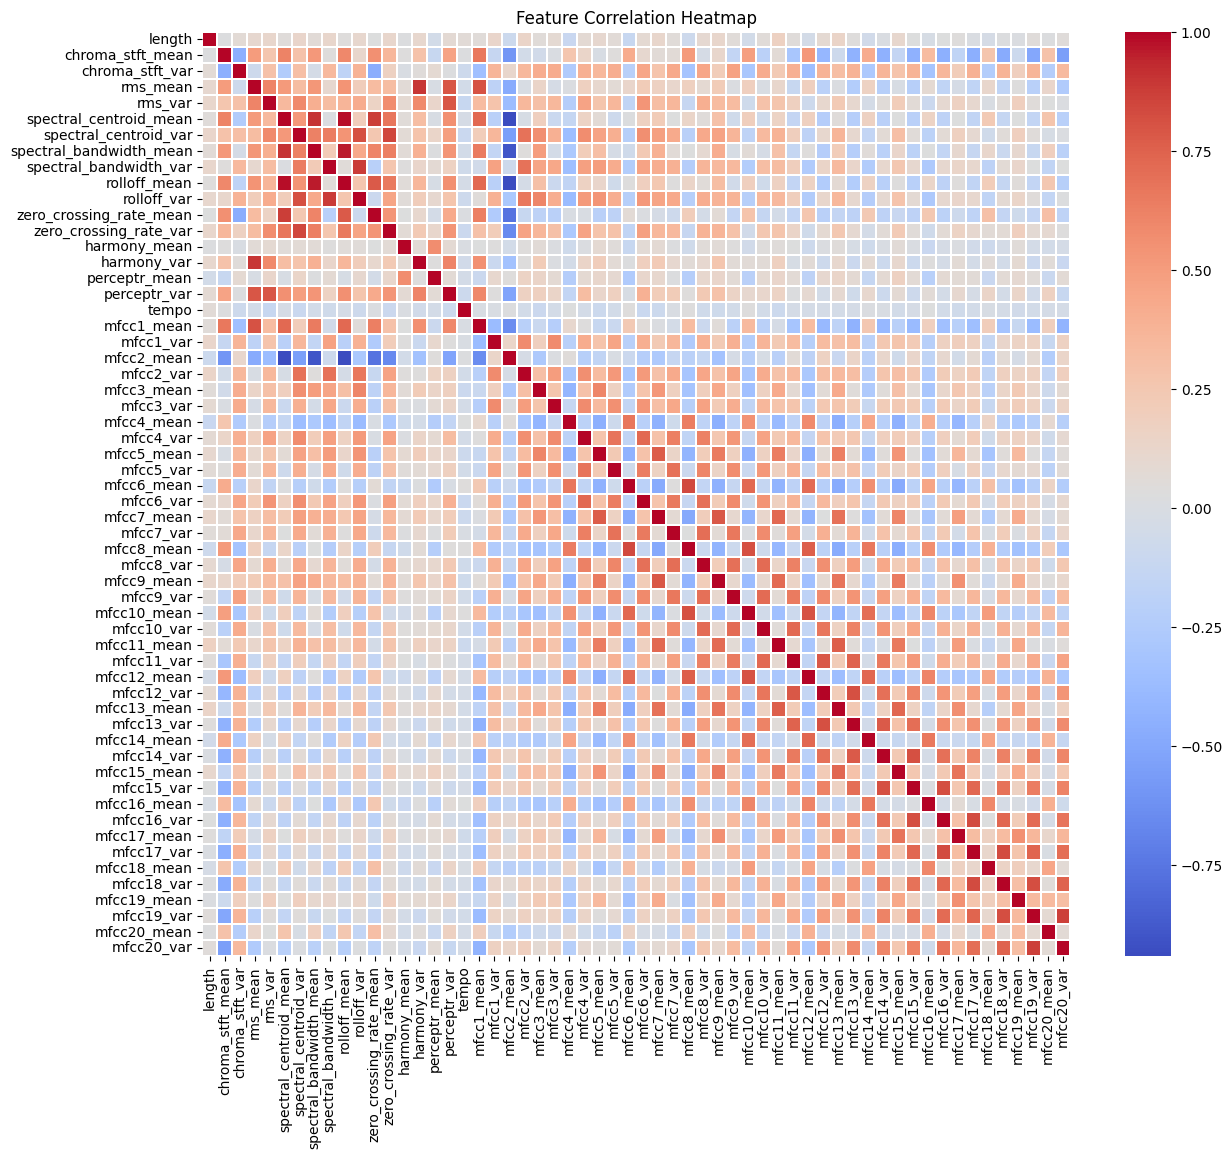

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(14, 12))
corr = features_30.drop(columns=['filename', 'label']).corr()
sns.heatmap(corr, cmap="coolwarm", linewidths=0.1)
plt.title("Feature Correlation Heatmap")
plt.show()

# Insights from the heatmap:
# Strong correlation among MFCC features
# Spectral features (centroid, bandwidth) also correlated
# Indicates multicollinearity

****Potential Issues************


---


**Issue--------------------	Explanation**

Multicollinearity---------	MFCCs and spectral features are highly correlated → may confuse linear models

Feature scale mismatch---	Variances and means exist together. Scaling required

Genre overlap------------	Jazz, Blues, Classical show overlapping feature ranges

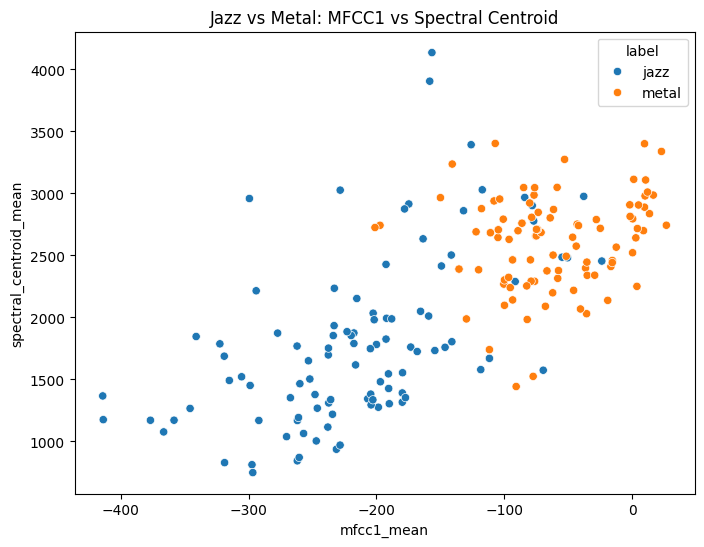

In [ ]:
# Jazz vs Metal Scatter Plot
jazz_metal = features_30[features_30['label'].isin(['jazz', 'metal'])]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=jazz_metal,
    x='mfcc1_mean',
    y='spectral_centroid_mean',
    hue='label'
)
plt.title("Jazz vs Metal: MFCC1 vs Spectral Centroid")
plt.show()


# Insights:
# Metal shows higher spectral centroid (brighter, harsher sounds)
# Jazz clusters lower and tighter

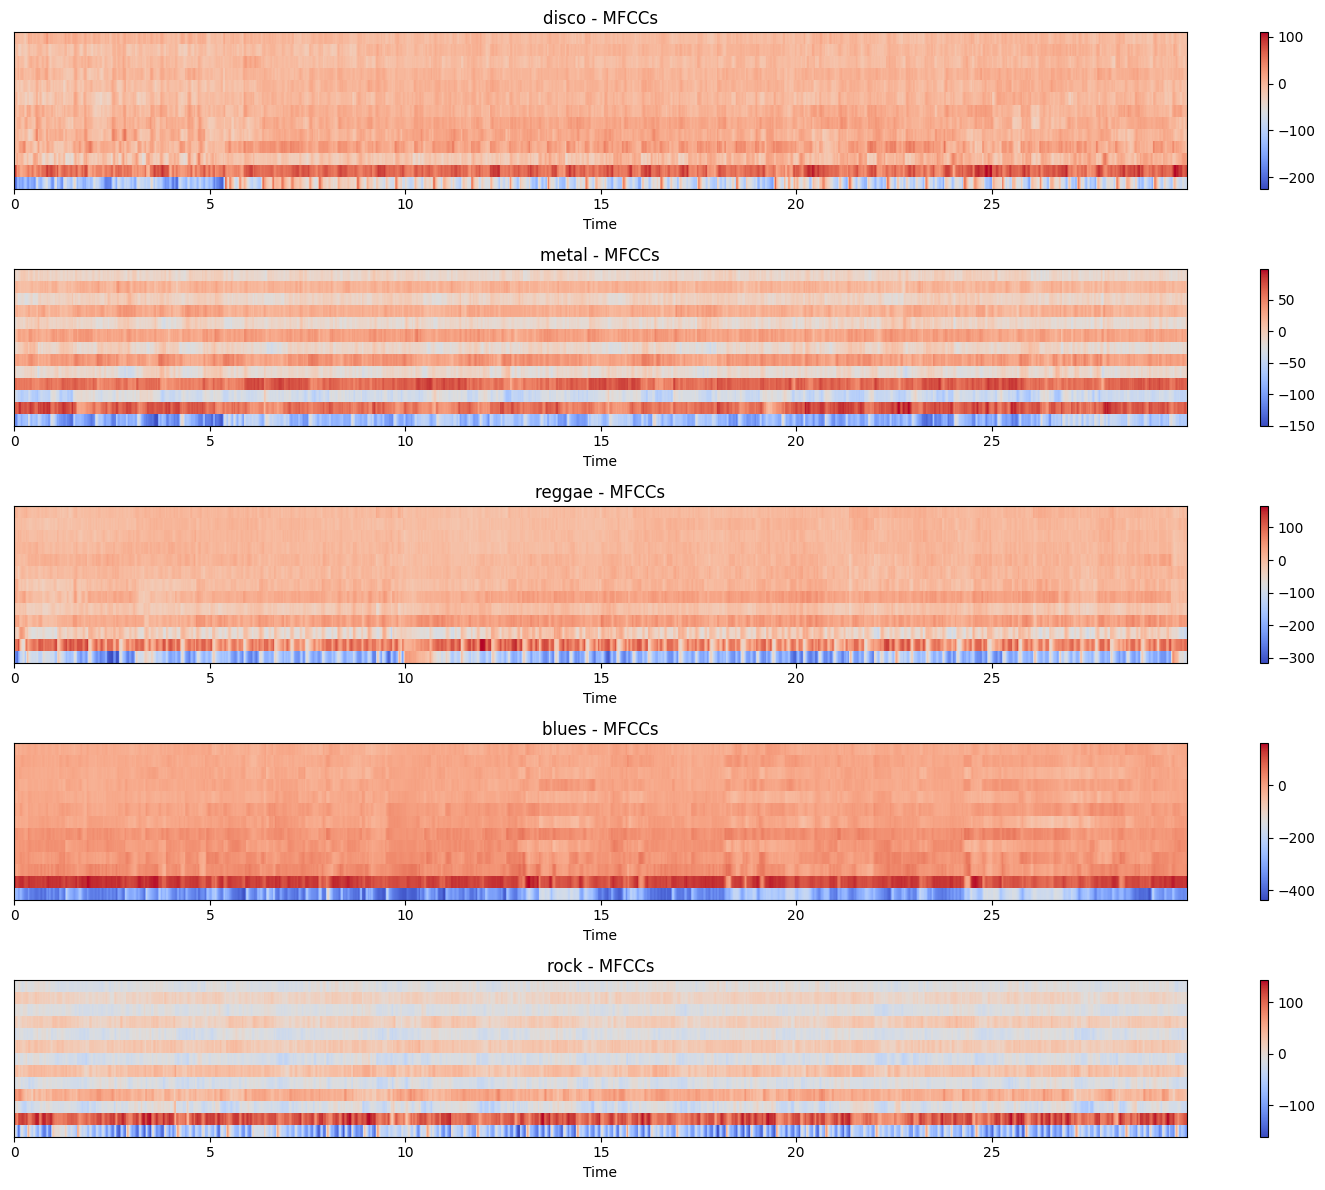

In [ ]:
# MFCC Visualization (First 5 Songs)
audio_path = "/path_to_audio_files"
genres = os.listdir(audio_path)

plt.figure(figsize=(15,12))

count = 1
for genre in genres[:5]:
    files = os.listdir(os.path.join(audio_path, genre))
    file_path = os.path.join(audio_path, genre, files[0])

    y, sr = librosa.load(file_path, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.subplot(5,1,count)
    librosa.display.specshow(mfcc, x_axis="time")
    plt.colorbar()
    plt.title(f"{genre} - MFCCs")
    count += 1

plt.tight_layout()
plt.show()

In [ ]:
# XGBoost Model
features_3 = pd.read_csv("/Dataset_Path/Datasetfilename.csv")

X = features_3.drop(columns=["filename", "label"])
y = features_3["label"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=77
)

In [ ]:
# Train XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=10,
    eval_metric="mlogloss"
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=10, ...)

In [ ]:
# XGBoost Evaluation
y_pred = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))




Accuracy: 0.9144144144144144
              precision    recall  f1-score   support

       blues       0.93      0.91      0.92       200
   classical       0.95      0.96      0.96       200
     country       0.86      0.90      0.88       199
       disco       0.90      0.90      0.90       200
      hiphop       0.92      0.91      0.92       199
        jazz       0.91      0.93      0.92       200
       metal       0.97      0.92      0.94       200
         pop       0.98      0.91      0.94       200
      reggae       0.89      0.92      0.90       200
        rock       0.85      0.88      0.87       200

    accuracy                           0.91      1998
   macro avg       0.92      0.91      0.91      1998
weighted avg       0.92      0.91      0.91      1998



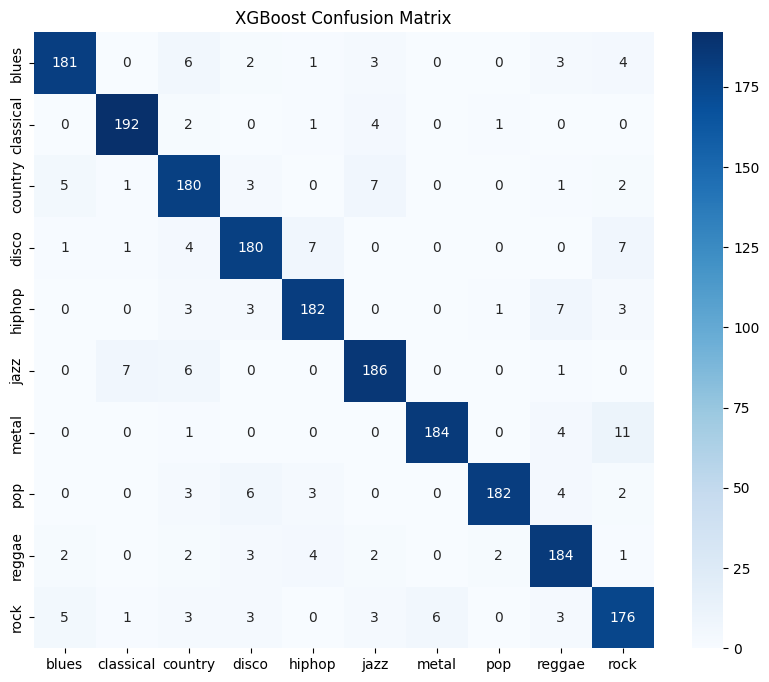

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("XGBoost Confusion Matrix")
plt.show()


In [ ]:
# CNN Data Preparation (Spectrogram Images)
img_path = "DatasetImagePath"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    img_path,
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    img_path,
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


In [ ]:
# CNN Model Architecture
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-09 20:04:20.602495: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,519,498 (24.87 MB)

 Trainable params: 6,519,050 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train CNN
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1676 - loss: 19.3789 - val_accuracy: 0.1005 - val_loss: 5.5925
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 922ms/step - accuracy: 0.1856 - loss: 2.2053 - val_accuracy: 0.1005 - val_loss: 20.6728
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 924ms/step - accuracy: 0.2023 - loss: 2.1298 - val_accuracy: 0.1005 - val_loss: 33.7007
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 905ms/step - accuracy: 0.2244 - loss: 2.0854 - val_accuracy: 0.1005 - val_loss: 40.6339
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 969ms/step - accuracy: 0.2346 - loss: 2.0567 - val_accuracy: 0.1005 - val_loss: 46.7712
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 921ms/step - accuracy: 0.2524 - loss: 1.9888 - val_accuracy: 0.1005 - val_loss: 58.6513
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 962ms/step - accuracy: 0.1987 - loss: 2.1876 - val_accuracy: 0.1005 - val_loss: 69.4684
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 917ms/step - accuracy: 0.2000 - loss: 2.1094 - val_

In [ ]:
# Model Comparison
comparison = pd.DataFrame({
    "Model": ["XGBoost (Audio Features)", "CNN (Spectrogram Images)"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        max(history.history["val_accuracy"])
    ]
})

comparison


,Model,Accuracy
0,XGBoost (Audio Features),0.914414
1,CNN (Spectrogram Images),0.120603


**Futher Steps: Implement Transfer Learning**

In [ ]:
# Imports required libraries
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Improved Image Preprocessing

# EfficientNet expects images scaled to [0,1] (already correct).

img_path = "DatasetFilePath"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=False
)

train_gen = datagen.flow_from_directory(
    img_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    img_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


In [ ]:
# Load Pretrained Backbone (EfficientNet)
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # freeze pretrained layers

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build Transfer Learning Model
model_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, activation="softmax")
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_tl.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,381,101 (16.71 MB)

 Trainable params: 331,018 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [ ]:
# Callbacks for Stable Training
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)


In [ ]:
# Train Transfer Learning Model
history_tl = model_tl.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1179 - loss: 2.6929 - val_accuracy: 0.0955 - val_loss: 2.3708 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.0737 - loss: 2.6132 - val_accuracy: 0.1005 - val_loss: 2.3861 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.0925 - loss: 2.5644 - val_accuracy: 0.1005 - val_loss: 2.3601 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.1108 - loss: 2.4788 - val_accuracy: 0.1005 - val_loss: 2.3467 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.0952 - loss: 2.4771 - val_accuracy: 0.1005 - val_loss: 2.3862 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.0808 - loss: 2.5205 - val_accuracy: 0.1005 - val_loss: 2.4213 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1158 - loss: 2.5033 - val_accuracy: 

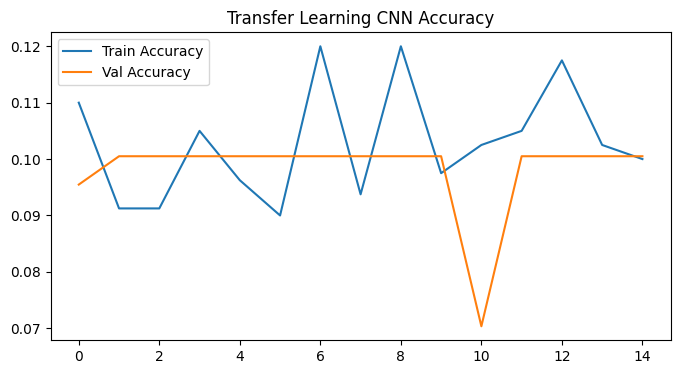

In [ ]:
# Evaluate Transfer Learning CNN
plt.figure(figsize=(8,4))
plt.plot(history_tl.history["accuracy"], label="Train Accuracy")
plt.plot(history_tl.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Transfer Learning CNN Accuracy")
plt.show()

In [ ]:
# Fine-Tuning. Unfreeze the top layers of EfficientNet for genre-specific learning.

base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

In [ ]:
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_ft = model_tl.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.0973 - loss: 3.1587 - val_accuracy: 0.1005 - val_loss: 2.3264 - learning_rate: 1.0000e-04
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.0922 - loss: 3.0300 - val_accuracy: 0.1005 - val_loss: 2.3277 - learning_rate: 1.0000e-04
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.0973 - loss: 3.0985 - val_accuracy: 0.1005 - val_loss: 2.3475 - learning_rate: 1.0000e-04
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.1062 - loss: 3.0476 - val_accuracy: 0.1005 - val_loss: 2.3860 - learning_rate: 1.0000e-04
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.0967 - loss: 2.8892 - val_accuracy: 0.1005 - val_loss: 2.3907 - learning_rate: 3.0000e-05
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.0969 - loss: 2.8933 - val_accuracy: 0.1005 - val_loss: 2.3973 - learning_rate: 3.0000e-05


In [ ]:
# Cell 23 b — Final CNN Evaluation
val_loss, val_acc = model_tl.evaluate(val_gen)
print("Final Validation Accuracy:", val_acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.1106 - loss: 2.3170
Final Validation Accuracy: 0.10050251334905624


In [ ]:
# Updated Model Comparison Table
comparison = pd.DataFrame({
    "Model": [
        "XGBoost (Audio Features)",
        "CNN (From Scratch)",
        "CNN (Transfer Learning)"
    ],
    "Validation Accuracy": [
        accuracy_score(y_test, y_pred),
        max(history.history["val_accuracy"]),
        val_acc
    ]
})

comparison

,Model,Validation Accuracy
0,XGBoost (Audio Features),0.914414
1,CNN (From Scratch),0.120603
2,CNN (Transfer Learning),0.100503


In [ ]:
# To confirm why the results for CNN were poor:
np.unique(np.argmax(model_tl.predict(val_gen), axis=1), return_counts=True)
# Interpretation:
# array([3]) → only ONE class index is ever predicted
# array([199]) → it was predicted 199 times
# Your test set has 199 samples
# The CNN predicts class “3” for every single image.

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


(array([3]), array([199]))

In [ ]:
# Quick Diagnostic Plots. Check class distribution in test set
import collections
collections.Counter(val_gen.classes)
# If test data is balanced but predictions aren’t,  model failure confirmed.

Counter({np.int32(0): 20,
         np.int32(1): 20,
         np.int32(2): 20,
         np.int32(3): 20,
         np.int32(4): 20,
         np.int32(5): 19,
         np.int32(6): 20,
         np.int32(7): 20,
         np.int32(8): 20,
         np.int32(9): 20})